## Inversion for a coupled acoustic-gravity system

Before running `pip install tinyda ray' 

### Problem setup

Let $\varphi$ be the potential for the flow velocity, it is solution to 
\begin{align}\label{eq:forwardmodel}
    \frac{\partial^2 \varphi}{\partial t^2}
    - c^2 \Delta \varphi 
    + g \frac{\partial \varphi}{\partial z}
    = 0,  \quad \text{ in } \Omega,
    \\
    \frac{\partial^2 \varphi}{\partial t^2}
    + g \frac{\partial \varphi}{\partial z} 
    = 0, \quad \text{ on } \Gamma_s,
    \\
    \nabla \varphi \cdot {\bf n}
    = u_b, \quad \text{ on } \Gamma_b,
\end{align}
where $c$ is the (constant) sound speed, $g$ is the gravity acceleration, ${\bf n}$ is the outwards unit vector normal to the seabed $\Gamma_b$ and $u_b$ is the seabed velocity.
The fluid displacement $u$ is related to the potential by $u = \nabla \varphi$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm, rv_continuous, wasserstein_distance
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix

import tinyDA as tda
import umbridge

/home/anne/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Initialising UM-Bridge
Before running the following cell, the model Docker image must be started from a system terminal using

`docker run -it -p 4242:4242 acousticgravity`

The Dockerfile can be found in the acousticgracity branch on UM-Bridge benchmarks. If not just running on a local machine replace `localhost` with the server.

In [2]:
# Create the config data
#### Change captor location and number
# Each element of the list "captors" is a tuple of (x,z) coordinates. 
# // version without PML: x should be between 6 and 36, z should be between 0 and (strictly less than) 1. 
# // version with PML: x should be between 1 and 29, z should be between 0 and (strictly less than) 1. 
captors = [(10,0.5), (22,0.9)] #[(28,0.5), (20,0.9)]

#### do not change this part
captors = np.array(captors, dtype=[('x',float),('y',float)])
captors = np.sort(captors, order=['x','y'])
fixedFloor= np.array([0,1]) # np.linspace(0,5,6)
Lx, Nx = 30, 150
Lz, Nz = 1, 10
for i in range(len(captors)):
    xCapt = captors[i][0]*Nx/Lx
    fixedFloor = np.concatenate((fixedFloor, [xCapt-2, xCapt-1, xCapt, xCapt+1, xCapt+2]))
fixedFloor=np.concatenate((fixedFloor, np.array([Nx-2,Nx-1])))  #np.concatenate((fixedFloor, np.linspace(37,42,6)))
fixedFloor=np.unique(fixedFloor)
fixedFloor=fixedFloor.tolist()
captors = captors.tolist()
print(fixedFloor)



def fill_input(_input, fixedFloor):
    full = np.zeros(Nx)
    counter = 0
    for i in range(len(full)):
        if i not in fixedFloor: 
            full[i] = _input[counter]
            counter +=1 
    return full

[0.0, 1.0, 48.0, 49.0, 50.0, 51.0, 52.0, 108.0, 109.0, 110.0, 111.0, 112.0, 148.0, 149.0]


In [3]:
# connect to the UM-Bridge model.
umbridge_model = umbridge.HTTPModel('http://localhost:4242', "forward")

# wrap the UM-Bridge model in the tinyDA UM-Bridge interface.

#config={"fixedFloor":[0,1,2,3,4,5,26,27,28,29,30,36,37,38,39,40,41,42]} 
config={"fixedFloor":fixedFloor, "captors":captors}
my_model = tda.UmBridgeModel(umbridge_model, umbridge_config=config)


In [4]:
nx = umbridge_model.get_input_sizes(config)[0] #the input is the value of f(x) at each grid point
ny = umbridge_model.get_output_sizes(config)[0] #the outout is a time series of the pressure
print(f"input:{nx}, output:{ny}")

input:136, output:318


### Example of input creation

In [5]:
length_scale = 5.0
eps = 1e-6
decay_rate = 10

x = np.linspace(0, nx - 1, nx).reshape(-1, 1)

def rbf_covariance(grid, length_scale, variance=1.0):
    dists = cdist(grid, grid, 'euclidean')
    return variance * np.exp(-0.5 * (dists / length_scale) ** 2)

cov = rbf_covariance(x, length_scale)
cov += eps * np.eye(nx)
mean = np.zeros(nx)
my_prior = multivariate_normal(mean=mean, cov=cov)

# def smooth_cut(x, x0, width, k):
#     step1 = 1 / (1 + np.exp(-k * (x - (x0 - width / 2))))
#     step2 = 1 / (1 + np.exp(-k * (x - (x0 + width / 2))))
#     return step1 - step2

# cut = smooth_cut(x.flatten(), nx / 2, nx * (1 - 14 / nx), decay_rate)

sample = my_prior.rvs()

def restriction(sampin):
    field_cut = sampin #* cut
    return (field_cut > eps).astype(int)

sample = restriction(sample)

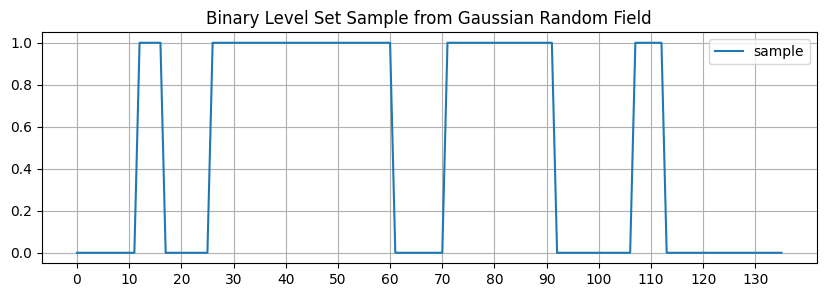

In [6]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.set_xticks([i for i in range(0,nx,10)])
ax.grid()

ax.plot(sample,label='sample')
#ax.plot(cut,label='smooth cut')
#ax.plot(sample * cut, label='cut sample')
ax.legend()
ax.set_title("Binary Level Set Sample from Gaussian Random Field")
plt.show()

### Problem setup

In [7]:
# generate synthetic data for input 0.5
# Input is a 15km wide fault centered around x
# Domain size is 150km
exact = np.zeros(nx)
# Should be between 0 and Nx
exact[60:80]=1
print(exact)
d_true = my_model(exact)

# add some noise to the model output
sigma_noise = 0.001
d = d_true + np.random.normal(loc=0, scale=sigma_noise, size=ny)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


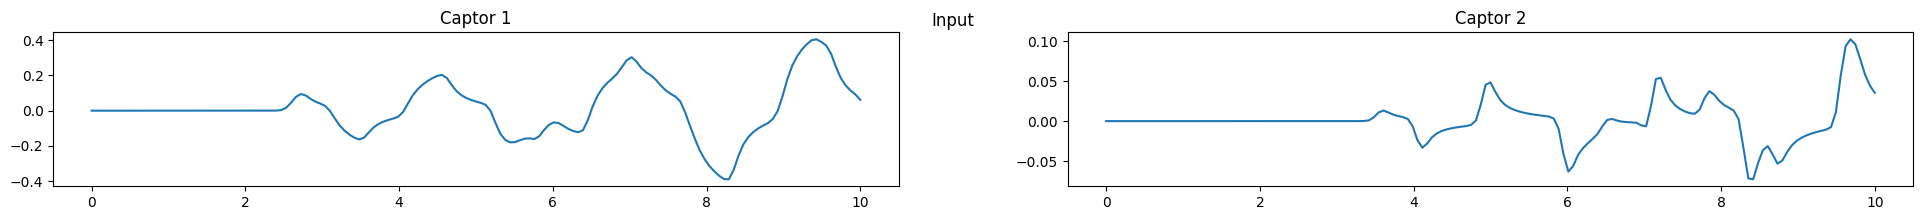

In [8]:
fig, ax = plt.subplots(1,2, figsize=(24,2), sharex=True)
fig.suptitle('Input')
x=np.linspace(0,nx, nx)
t=np.linspace(0,10, int(ny/2))

d_true1 = np.array(d_true)[0:ny:2]
d_true2 = np.array(d_true)[1:ny:2]

ax[0].set_title('Captor 1')
ax[0].plot(t,d_true1)

ax[1].set_title('Captor 2')
ax[1].plot(t,d_true2)


[10. 22.] [0.5 0.9]


Text(0.5, 1.0, 'Exact inputs')

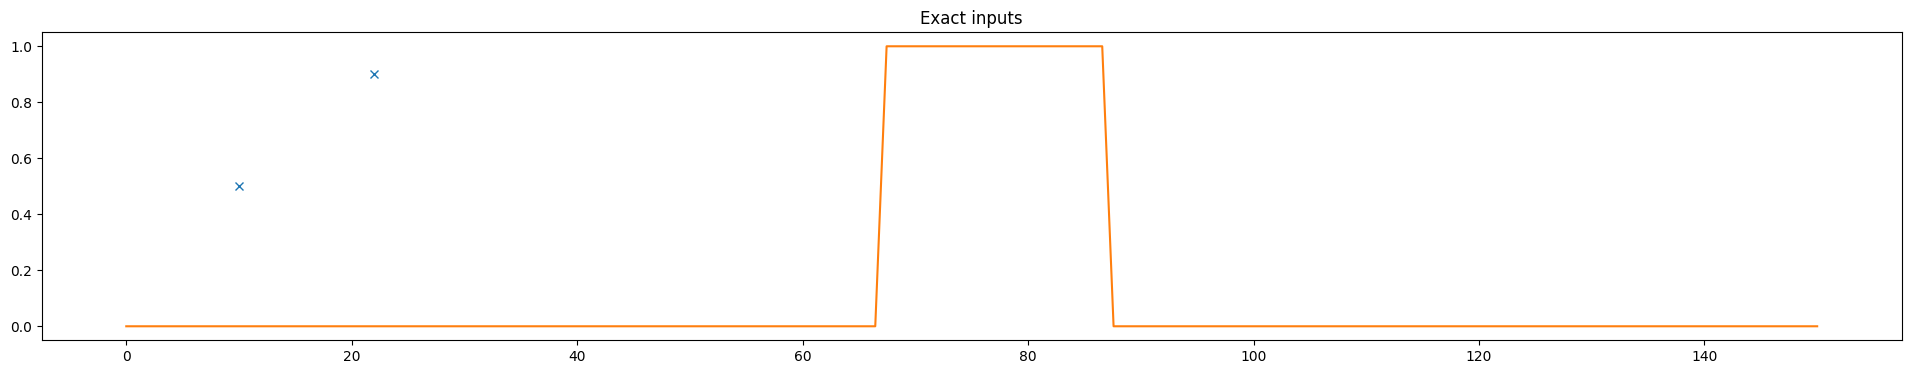

In [9]:
# plot several output and the exact (with/without noise) input/output


# exact (with/without noise) input/output 
xCapt = np.array(captors)[:,0]
yCapt = np.array(captors)[:,1]
print(xCapt, yCapt)

# Plot exact input
figIn, axIn = plt.subplots(figsize=(24,4))

axIn.plot(xCapt,yCapt,'x')
exact_full = fill_input(exact, fixedFloor)
axIn.plot(np.linspace(0,Nx,Nx), exact_full)
#axIn.set_xticks([i for i in range(0,30)])
axIn.set_title("Exact inputs")


# fig, ax = plt.subplots(ncols=2, figsize=(24,4))
# t = np.linspace(0,10,int(ny/2))
# d_true1 = np.array(d_true)[0:ny:2]
# d_true2 = np.array(d_true)[1:ny:2]

# d1 = np.array(d)[0:ny:2]
# d2 = np.array(d)[1:ny:2]

# ax[0].set_title('Pressure, captor 1')
# ax[0].plot(t,d_true1, label='Noise-free input')
# ax[0].plot(t,d1, label='Noisy input')
# ax[0].legend()

# ax[1].set_title('Pressure, captor 2')
# ax[1].plot(t,d_true2, label='Noise-free input')
# ax[1].plot(t,d2, label='Noisy input')
# ax[1].legend()



[ 50. 110.] [0.5 0.9]


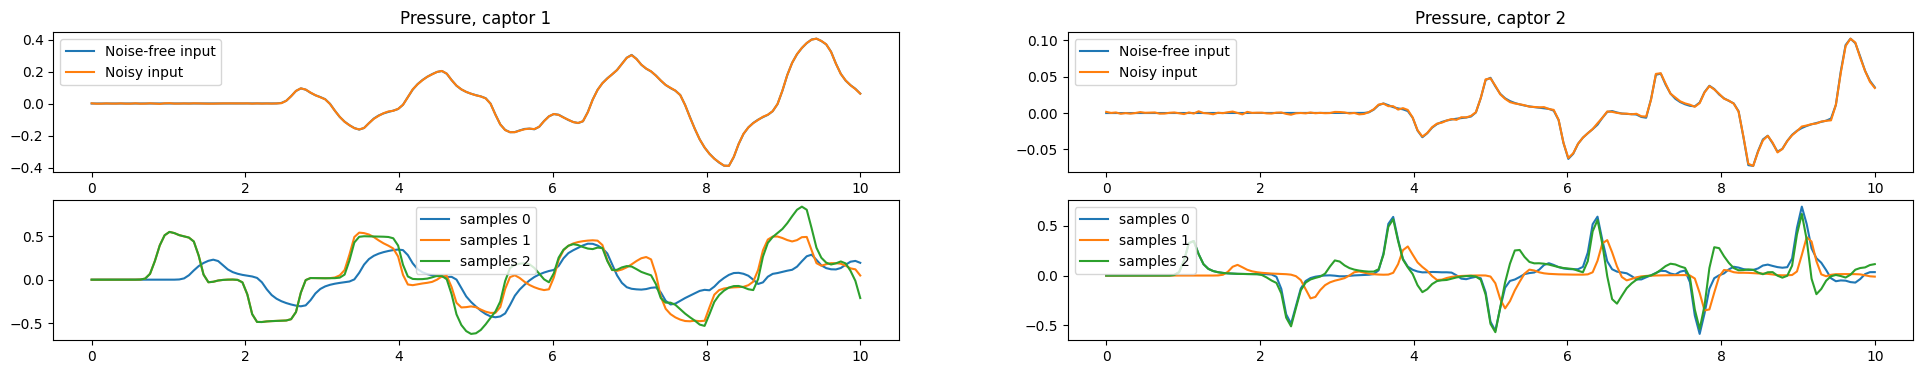

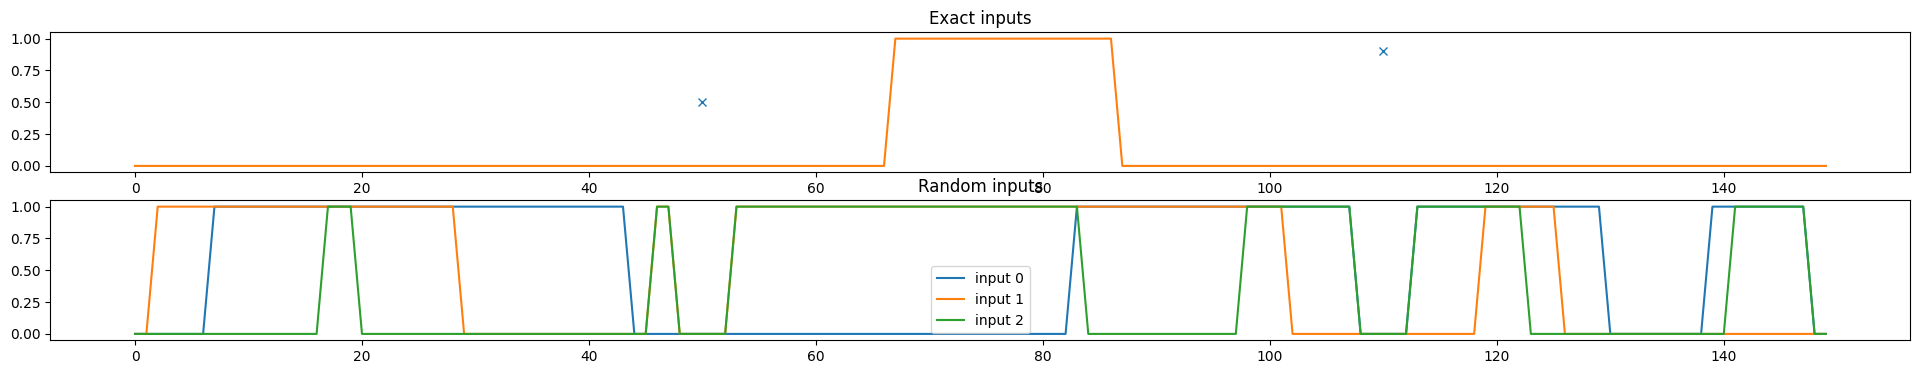

In [10]:
# plot several output and the exact (with/without noise) input/output
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24,4))
figIn, axIn = plt.subplots(nrows=2, figsize=(24,4))

# exact (with/without noise) input/output 
xCapt = np.array(captors)[:,0]*Nx/Lx
yCapt = np.array(captors)[:,1]*Nz/Nz
print(xCapt, yCapt)

axIn[0].plot(xCapt,yCapt,'x')
exact_full = fill_input(exact, fixedFloor)
axIn[0].plot(exact_full)
axIn[0].set_title("Exact inputs")

t = np.linspace(0,10,int(ny/2))
d_true1 = np.array(d_true)[0:ny:2]
d_true2 = np.array(d_true)[1:ny:2]

d1 = np.array(d)[0:ny:2]
d2 = np.array(d)[1:ny:2]

ax[0][0].set_title('Pressure, captor 1')
ax[0][0].plot(t,d_true1, label='Noise-free input')
ax[0][0].plot(t,d1, label='Noisy input')
ax[0][0].legend()

ax[0][1].set_title('Pressure, captor 2')
ax[0][1].plot(t,d_true2, label='Noise-free input')
ax[0][1].plot(t,d2, label='Noisy input')
ax[0][1].legend()


# Plot several random samples
samples = []
inputs=[]
for x in range(3):
     log = my_prior.rvs()
     log = restriction(log)
     d_sample = my_model(log)

     d_sample1 = np.array(d_sample)[0:ny:2]
     d_sample2 = np.array(d_sample)[1:ny:2]
     
     ax[1][0].plot(t, d_sample1, label=f'samples {x}')
     ax[1][1].plot(t, d_sample2, label=f'samples {x}')

     log_full = fill_input(log,fixedFloor)
     axIn[1].plot(range(len(log_full)), log_full, label=f'input {x}')
     samples.append(d_sample)
     inputs.append(log)

ax[1][0].legend()
ax[1][1].legend()
axIn[1].set_title("Random inputs")
axIn[1].legend()

plt.show()

## Set up log-likelihood

In [11]:
class wasserstein_loglike():
    def __init__(self, ground_truth):
        self.ground_truth = ground_truth
    
    def loglike(self,x):
        #x1 = np.array(x)[0:ny:2]
        #x2 = np.array(x)[1:ny:2]
        #g1 = np.array(self.ground_truth)[0:ny:2]
        #g2 = np.array(self.ground_truth)[1:ny:2]
        return - wasserstein_distance(x,self.ground_truth)/0.05

In [12]:
# # set the covariance of the likelihood.
# sigma = 0.125
# cov_likelihood = sigma**2*np.eye(d.shape[0])
# my_loglike = tda.GaussianLogLike(d, cov_likelihood)
my_loglike = wasserstein_loglike(d_true)

# initialise the Posterior
my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

In [13]:
for d_sample in samples:
    print(np.exp(my_loglike.loglike(d_sample)))

0.3000334988527916
0.20308765403581738
0.0897758371519039


### Set up the proposal

In [18]:
# Custom Crank-Nicolson with cutoff and levelset
class CrankNicolsonWithProjection(tda.CrankNicolson):
    def __init__(self, scaling, adaptive):
        super().__init__(scaling=scaling, adaptive=adaptive)

    def make_proposal(self, link):
        # make a pCN proposal.
        self.scaling = min(self.scaling, 1.0 - 1e-3)
        return restriction(np.sqrt(
            1 - self.scaling**2
        ) * link.parameters + self.scaling * np.random.multivariate_normal(
            self._mean, self.C
        ))

# preconditioned Crank-Nicolson
pcn_scaling = 0.15
pcn_adaptive = True
my_proposal = CrankNicolsonWithProjection(scaling=pcn_scaling, adaptive=pcn_adaptive)

# # random walk Metropolis
#rwmh_cov = np.eye(nx)
#rmwh_scaling = 0.1
#rwmh_adaptive = False
#my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

### Sample

In [19]:
# For testing purposes, iteration number is small for the given problem; Choose a larger number for real applications.
my_chains = tda.sample(my_posterior, my_proposal, iterations=500, n_chains=2, force_sequential=True)

Sampling chain 1/2


Running chain, α = 0.54: 100%|████████████████| 500/500 [17:30<00:00,  2.10s/it]


Sampling chain 2/2


Running chain, α = 0.42: 100%|████████████████| 500/500 [10:10<00:00,  1.22s/it]


### Get some diagnostics

In [20]:
import arviz as az

In [36]:
# convert the tinyDA chains to an ArViz InferenceData object.
idata = tda.to_inference_data(my_chains, burnin=400)

/home/anne/.local/lib/python3.12/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [37]:
# display posterior summary statistics.
info = az.summary(idata)
info

/home/anne/.local/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/anne/.local/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/anne/.local/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,0.535,0.500,0.0,1.0,0.065,0.046,59.0,59.0,1.02
x1,0.475,0.501,0.0,1.0,0.056,0.040,79.0,79.0,1.01
x2,0.470,0.500,0.0,1.0,0.061,0.043,68.0,68.0,1.01
x3,0.475,0.501,0.0,1.0,0.059,0.042,71.0,71.0,1.01
x4,0.490,0.501,0.0,1.0,0.064,0.045,62.0,62.0,0.99
...,...,...,...,...,...,...,...,...,...
x131,0.515,0.501,0.0,1.0,0.054,0.038,87.0,87.0,1.02
x132,0.505,0.501,0.0,1.0,0.055,0.039,83.0,83.0,1.01
x133,0.500,0.501,0.0,1.0,0.058,0.041,75.0,75.0,1.02
x134,0.480,0.501,0.0,1.0,0.056,0.040,81.0,81.0,1.02


/home/anne/.local/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (136), generating only 20 plots
  warnings.warn(


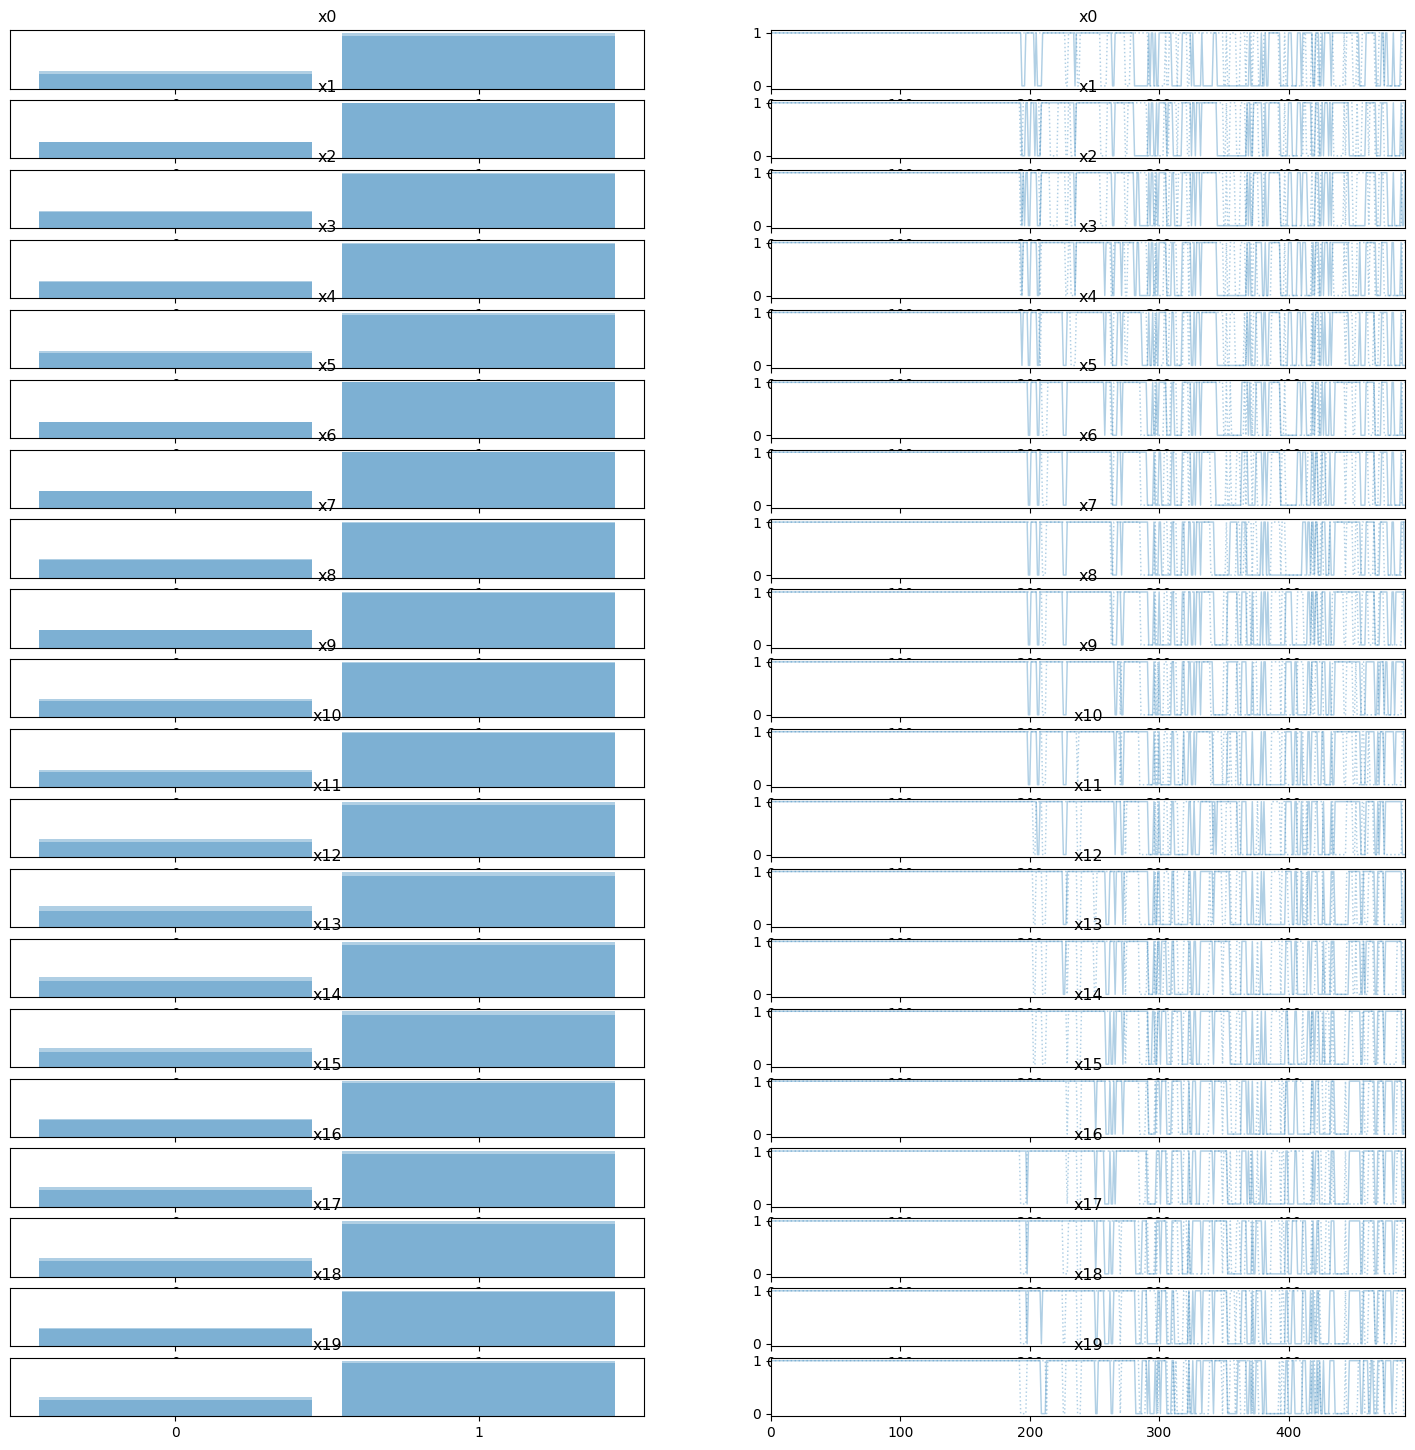

In [23]:
# plot posterior kernel densities and traces.
az.plot_trace(idata, figsize=(18, 18))
plt.show()

In [90]:
# extract the parameters from the chains.
parameters = [link.parameters for link in my_chains['chain_0'][2001:] + my_chains['chain_1'][2001:]]

In [ ]:
# plot some posterior draws of the model input and output.
n_samples = 1000
ids = np.random.randint(0, len(parameters), n_samples)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))

# plot the output pressure
ax.set_title('Pressure')
ax.plot(np.linspace(0,1,ny), d)
for i in ids:
    ax.plot(np.linspace(0,1,ny), my_model(parameters[i]), c='k', alpha=0.01)
plt.show()

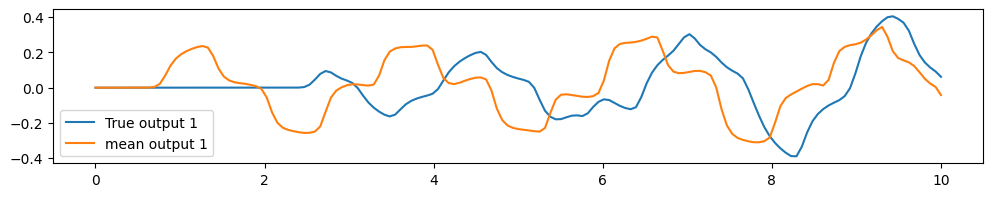

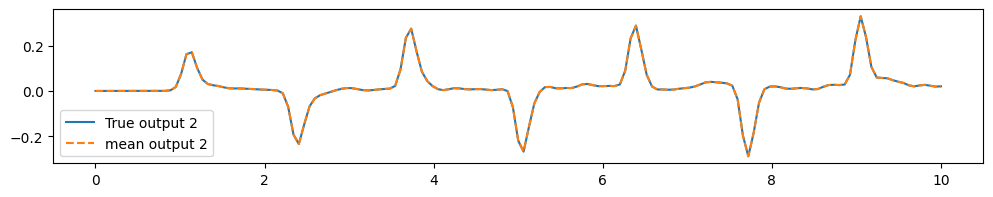

In [38]:
fig, ax = plt.subplots(figsize=(12,2))
x=np.linspace(0,nx, nx)
t=np.linspace(0,10, int(ny/2))
d1 = np.array(d_true)[0:ny:2]
d2 = np.array(d_true)[1:ny:2]
ax.plot(t,d1, label='True output 1')
output = my_model(info['mean'])
d1 = np.array(output)[0:ny:2]
d2 = np.array(output)[1:ny:2]
ax.plot(t,d1, label='mean output 1')
ax.legend()

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(t,d2, label='True output 2')
ax.plot(t,d2, '--' ,label='mean output 2')
ax.legend()

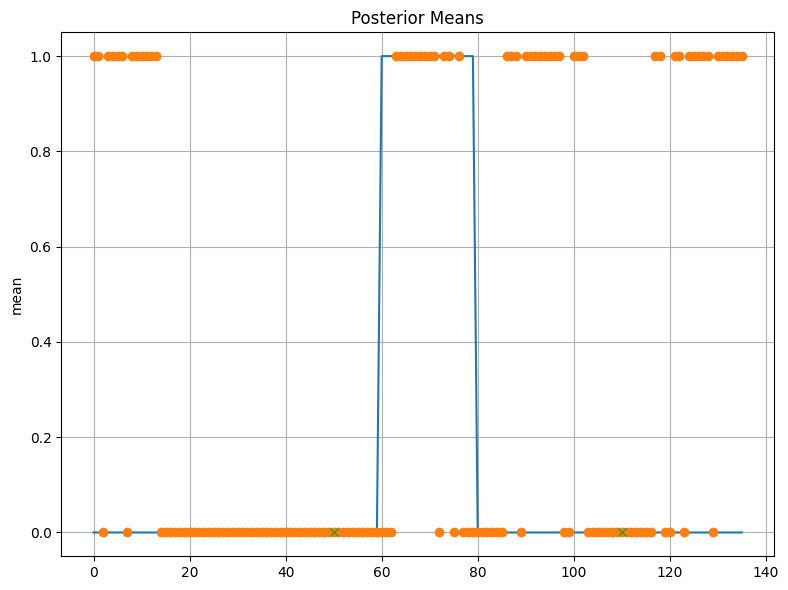

In [39]:
x = range(len(info))
plt.figure(figsize=(8, 6))
plt.plot(exact)
plt.title('Exact input')
plt.plot(x, info['mean']>0.47, 'o')  # x = index, y = mean
plt.plot([captors[0][0]*Nx/Lx,captors[1][0]*Nx/Lx],[0,0],'x')
plt.ylabel('mean')
plt.title('Posterior Means')
plt.grid(True)
plt.tight_layout()
plt.show()